In [88]:
# Imports
import numpy as np
import pandas as pd
# Charts
import seaborn as sns
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Snowflake credentials
import json
from pathlib import Path
snowflake_cred_path = str(Path.home()) + '/.ssh/snowflake_cred.json'
with open(snowflake_cred_path) as file:
    secret_dict = json.load(file)
    

In [107]:
# Seaborn Charts personalisation
import seaborn as sns
chart_color = "#eae8e3ff"
sns.set(rc={'axes.facecolor':chart_color, 'axes.edgecolor': chart_color, 'figure.facecolor':chart_color, 'grid.color':".3","grid.linestyle": ":"})

In [89]:
from snowflake.snowpark import Session

connection_parameters = {
    'account': secret_dict['account'],
    'user': secret_dict['user'],
    'password': secret_dict['password'],
    'role': secret_dict['role'],
    'warehouse': secret_dict['warehouse'],
    'database': secret_dict['database'],
    'schema': secret_dict['schema']
}

session = Session.builder.configs(connection_parameters).create()

# Tables creation in Snowflake (only run once)

#### 1 Mappnig CUSTOMER_KEY with SESSION_KEY and GCLID (LAST 90 days - last run 2023-03-17)

In [165]:
last_run = "20230322"
banner = 'banner'

In [ ]:
# Users - Mapping customer_key with session_key
sql = f"""
CREATE or replace TRANSIENT TABLE "DATASET_ID"."LTV"."STG_GA_{banner}_CUSTOMERS_SESSION_MAPPING_{last_run}" AS (

WITH customer_sessions AS (
SELECT
    CUSTOMER_KEY,
    SESSION_KEY
FROM
    DATASET_ID.INTERMEDIATE.INT_GA_CUSTOM_CUSTOMER_KEY
WHERE 
    BANNER = '{banner}'    
 
)

SELECT DISTINCT
    a.SESSION_KEY,
    b.CUSTOMER_KEY,
    a.SESSION_DATE,
    a.GCL_ID,
    a.CAMPAIGN_ID,
    a.SOURCE, 
    a.AD_NETWORK_TYPE
    
FROM
    DATASET_ID.STAGING.STG_GA__SESSIONS_DAILY__TRAFFIC_SOURCE a 
LEFT JOIN customer_sessions b
ON(a.SESSION_KEY = b.SESSION_KEY)
WHERE 
    a.SESSION_DATE BETWEEN DATEADD(DAY,-90,CURRENT_DATE()) and CURRENT_DATE()
    AND a.GCL_ID is not NULL

)
"""
session.sql(sql).collect()


In [ ]:
# Grabbing the more recent gclid for each user 

sql = f"""
CREATE or replace TRANSIENT TABLE "DATASET_ID"."LTV"."STG_GA_{banner}_MORE_RECENT_GCLID_CUSTOMER_KEY_{last_run}" AS (

SELECT
CUSTOMER_KEY, 
SESSION_DATE,
GCL_ID,
CAMPAIGN_ID,
SOURCE, 
AD_NETWORK_TYPE

FROM (

SELECT DISTINCT
   CUSTOMER_KEY,
   SESSION_DATE,
   GCL_ID,
   CAMPAIGN_ID,
   SOURCE, 
   AD_NETWORK_TYPE,
   ROW_NUMBER() OVER(PARTITION BY CUSTOMER_KEY ORDER BY SESSION_DATE DESC) as n_session
FROM
   "DATASET_ID"."LTV"."STG_GA_{banner}_CUSTOMERS_SESSION_MAPPING_{last_run}"
WHERE GCL_ID is not Null  and CUSTOMER_KEY is not NULL
 )
 WHERE n_session = 1
)
"""
session.sql(sql).collect()

### 2 . Creating transactional table (client, revenue, quantity) - USING GA DATA ONLY

In [ ]:
sql = f"""
CREATE or replace TRANSIENT TABLE "DATASET_ID"."LTV"."STG_CUSTOMER_TRANSACTIONS_ONLINE_{banner}" AS (

SELECT
    CUSTOMER_KEY,
    BANNER,
    ORDER_NUMBER,
    DEMAND_ORDER_DATE,
    SUM(UNIT_PRICE*DEMAND_QTY) as TOTAL_DEMAND_GROSS_AMT,
    SUM(DEMAND_AMT*DEMAND_QTY) as TOTAL_DEMAND_AMT,
    SUM(DEMAND_QTY) as TOTAL_DEMAND_QTY
FROM
    "DATASET_ID"."CORE"."FCT_DEMAND"
WHERE 
    BANNER = '{banner}'    
AND
    DEMAND_ORDER_DATE BETWEEN '2021-03-01' and '2023-02-28' 
GROUP BY
    CUSTOMER_KEY,
    BANNER,
    ORDER_NUMBER,
    DEMAND_ORDER_DATE
ORDER BY
    CUSTOMER_KEY,
    BANNER,
    ORDER_NUMBER,
    DEMAND_ORDER_DATE


)
"""
session.sql(sql).collect()

### 3. Creating transactional table (client, revenue, quantity) - USING STORE AND ONLINE TRANSACTIONS

In [ ]:
sql = f"""

CREATE or replace TRANSIENT TABLE "DATASET_ID"."LTV"."STG_CUSTOMER_TRANSACTIONS_{banner}" AS (

WITH DATABASE_CUSTOMERS AS (
    SELECT DISTINCT CUSTOMER_KEY
    FROM "DATASET_ID"."CORE"."DIM_CUSTOMERS"
    WHERE
        BANNER = '{banner}'
        AND CREATE_SOURCE NOT LIKE 'INT%'
)

SELECT
    d.CUSTOMER_KEY
    , IFF(SALES_CHANNEL = 'STORE', TRANSACTION_ID, ORDER_NUMBER) as NEW_TRANSACTION_ID
    , IFF(SALES_CHANNEL = 'STORE', TRANSACTION_DATE, TO_DATE(ORDER_CAPTURE_DATE, 'MM/DD/YYYY HH24:MI:SS')) NEW_DATE
    , SALES_CHANNEL
    , SUM(LINE_AMOUNT_BEFORE_DISCOUNT) AS AMOUNT_BEFORE_DISCOUNT
    , SUM(LINE_AMOUNT_AFTER_DISCOUNT) AS AMOUNT_AFTER_DICOUNT
FROM DATABASE_CUSTOMERS d
JOIN "DATASET_ID"."CORE"."FCT_SA_TRANSACTIONS" t ON d.CUSTOMER_KEY = t.CUSTOMER_KEY
WHERE
    BANNER = '{banner}'
    AND NEW_DATE BETWEEN '2021-03-01'::DATE AND '2023-02-28'::DATE
    AND SALES_RETURNS_INDICATOR = 'Sale'
    AND LINE_VOID_FLAG = 'N'
    AND TRANSACTION_VOID_FLAG = 'N'
    AND SA_REJECTION_FLAG = 'N'
    AND IF_REJECTION_FLAG = 'N'
GROUP BY
   d.CUSTOMER_KEY
   ,NEW_TRANSACTION_ID
   ,NEW_DATE
   ,SALES_CHANNEL

ORDER BY
    d.CUSTOMER_KEY
    , NEW_TRANSACTION_ID
)

"""
session.sql(sql).collect()

### 4. Mapping gclid and customer_key for transacted users

In [ ]:
sql = f"""
CREATE or replace TRANSIENT TABLE "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}" AS (

WITH transactions AS (
SELECT 
  a.CUSTOMER_KEY,
  a.SALES_CHANNEL,
  COUNT(DISTINCT NEW_TRANSACTION_ID) as N_TRANSACTIONS
FROM
  "DATASET_ID"."LTV"."STG_CUSTOMER_TRANSACTIONS_{banner}" a
GROUP BY 1, 2
  )
  
SELECT
  a.CUSTOMER_KEY,
  a.SALES_CHANNEL,
  a.N_TRANSACTIONS,
  b.GCL_ID,
  b.SESSION_DATE
FROM 
    transactions a

FULL JOIN "DATASET_ID"."LTV"."STG_GA_{banner}_MORE_RECENT_GCLID_CUSTOMER_KEY_{last_run}" b
ON(a.CUSTOMER_KEY = b.CUSTOMER_KEY)

)
"""
session.sql(sql).collect()

# Exploratory analysis: users and transactions 

### Number of transactions and users:
The idea is to have a sense of how many users there are in the dataset in the two years period that we are working with.
We calculate:
- The number of users with STORE transactions (offline) and how many transactions they did
- The number of users with ECOMMERCE transactions (online) and how many transaction they did
- The number of users with ONLY STORE transactions
- The number of users with ONLY ECOMMERCE transactions

Also, we calculate the same but only for users with a valid gclid in the dataset (users that would be tracked by google ads)

Last, because there is a 90 days lookback window between click and conversion, we also calculate the same but only for users with a valid gclid in the last 90 days.

We create some venn diagrama to visualize this

In [103]:
sql = f"""
SELECT
    COUNT(DISTINCT IFF(GCL_ID IS NOT NULL AND N_TRANSACTIONS > 1, CUSTOMER_KEY, NULL)) as users_valid_gclid_multiple_transactions,
    COUNT(DISTINCT IFF(GCL_ID IS NULL AND N_TRANSACTIONS > 1, CUSTOMER_KEY, NULL)) as users_invalid_gclid_multiple_transactions,
    COUNT(DISTINCT IFF(GCL_ID IS NOT NULL AND N_TRANSACTIONS = 1, CUSTOMER_KEY, NULL)) as users_valid_gclid_one_transaction,
    COUNT(DISTINCT IFF(GCL_ID IS NULL AND N_TRANSACTIONS = 1, CUSTOMER_KEY, NULL)) as users_invalid_gclid_one_transaction,
    COUNT(DISTINCT CUSTOMER_KEY) as total_users,
    
    SUM(IFF(GCL_ID IS NOT NULL AND N_TRANSACTIONS > 1, N_TRANSACTIONS, 0)) as transactions_valid_gclid_multiple_transactions,
    SUM(IFF(GCL_ID IS NULL AND N_TRANSACTIONS > 1, N_TRANSACTIONS, 0)) as transactions_invalid_gclid_multiple_transactions,
    SUM(IFF(GCL_ID IS NOT NULL AND N_TRANSACTIONS = 1, N_TRANSACTIONS, 0)) as transactions_valid_gclid_one_transaction,
    SUM(IFF(GCL_ID IS NULL AND N_TRANSACTIONS = 1, N_TRANSACTIONS, 0)) as transactions_invalid_gclid_one_transaction,
    SUM(N_TRANSACTIONS) AS total_transactions
FROM
  "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"

WHERE SALES_CHANNEL IS NOT NULL AND CUSTOMER_KEY IS NOT NULL
  
"""

resume = session.sql(sql).to_pandas()
resume.T

,0
USERS_VALID_GCLID_MULTIPLE_TRANSACTIONS,51720
USERS_INVALID_GCLID_MULTIPLE_TRANSACTIONS,643281
USERS_VALID_GCLID_ONE_TRANSACTION,33282
USERS_INVALID_GCLID_ONE_TRANSACTION,1121207
TOTAL_USERS,1728525
TRANSACTIONS_VALID_GCLID_MULTIPLE_TRANSACTIONS,406646
TRANSACTIONS_INVALID_GCLID_MULTIPLE_TRANSACTIONS,2618446
TRANSACTIONS_VALID_GCLID_ONE_TRANSACTION,37461
TRANSACTIONS_INVALID_GCLID_ONE_TRANSACTION,1181040
TOTAL_TRANSACTIONS,4243593


In [95]:
# Only users with 2 or more transactions

sql = f"""


SELECT
  SALES_CHANNEL,
  COUNT(DISTINCT CUSTOMER_KEY) as TOTAL_CUSTOMER_KEYS,
  SUM(N_TRANSACTIONS) as TOTAL_TRANSACTIONS
FROM "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
WHERE SALES_CHANNEL IS NOT NULL
AND CUSTOMER_KEY IN (
SELECT
  CUSTOMER_KEY
FROM 
  "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
GROUP BY 1
HAVING SUM(N_TRANSACTIONS) > 1
)

GROUP BY SALES_CHANNEL

UNION ALL

SELECT
  'STORE AND ECOMMERCE' AS SALES_CHANNEL,
  COUNT(DISTINCT CUSTOMER_KEY) as TOTAL_CUSTOMER_KEYS,
  SUM(N_TRANSACTIONS) as TOTAL_TRANSACTIONS
FROM "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
WHERE SALES_CHANNEL IS NOT NULL
AND CUSTOMER_KEY IN (
  SELECT
    CUSTOMER_KEY
  FROM 
   "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
  WHERE 
    SALES_CHANNEL IS NOT NULL
  GROUP BY CUSTOMER_KEY
  HAVING COUNT(DISTINCT SALES_CHANNEL) = 2
)
AND CUSTOMER_KEY IN (
SELECT
  CUSTOMER_KEY
FROM 
  "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
GROUP BY 1
HAVING SUM(N_TRANSACTIONS) > 1
)

UNION ALL

SELECT
  IFF(SALES_CHANNEL = 'ECOMMERCE', 'ECOMMERCE ONLY', 'STORE_ONLY') AS SALES_CHANNEL,
  COUNT(DISTINCT CUSTOMER_KEY) as TOTAL_CUSTOMER_KEYS,
  SUM(N_TRANSACTIONS) as TOTAL_TRANSACTIONS
FROM 
    "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
WHERE SALES_CHANNEL IS NOT NULL
AND CUSTOMER_KEY NOT IN (
  SELECT
      CUSTOMER_KEY
  FROM 
   "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
  WHERE 
    SALES_CHANNEL IS NOT NULL
  GROUP BY CUSTOMER_KEY
  HAVING COUNT(DISTINCT SALES_CHANNEL) = 2
)
AND CUSTOMER_KEY IN (
SELECT
  CUSTOMER_KEY
FROM 
  "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
GROUP BY 1
HAVING SUM(N_TRANSACTIONS) > 1
)
GROUP BY SALES_CHANNEL

UNION ALL

SELECT
  'TOTAL' as SALES_CHANNEL,
  COUNT(DISTINCT CUSTOMER_KEY) as TOTAL_CUSTOMER_KEYS,
  SUM(N_TRANSACTIONS) as TOTAL_TRANSACTIONS
FROM 
    "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
WHERE SALES_CHANNEL IS NOT NULL
AND CUSTOMER_KEY IN (
SELECT
  CUSTOMER_KEY
FROM 
  "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
GROUP BY 1
HAVING SUM(N_TRANSACTIONS) > 1
)
"""
users_transactions = session.sql(sql).to_pandas()
users_transactions.head()

,SALES_CHANNEL,TOTAL_CUSTOMER_KEYS,TOTAL_TRANSACTIONS
0,STORE AND ECOMMERCE,284435,1679917
1,TOTAL,759013,3274081
2,STORE,665658,2162565
3,STORE_ONLY,381223,1278940
4,ECOMMERCE,377790,1111516


In [104]:
total = users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0]  + users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0] + users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]
total

759013

In [94]:
# Total users

sql = f"""

SELECT
  SALES_CHANNEL,
  COUNT(DISTINCT CUSTOMER_KEY) as TOTAL_CUSTOMER_KEYS,
  SUM(N_TRANSACTIONS) as TOTAL_TRANSACTIONS
FROM "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
WHERE SALES_CHANNEL IS NOT NULL
GROUP BY SALES_CHANNEL

UNION ALL

SELECT
  'STORE AND ECOMMERCE' AS SALES_CHANNEL,
  COUNT(DISTINCT CUSTOMER_KEY) as TOTAL_CUSTOMER_KEYS,
  SUM(N_TRANSACTIONS) as TOTAL_TRANSACTIONS
FROM "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
WHERE SALES_CHANNEL IS NOT NULL
AND CUSTOMER_KEY IN (
  SELECT
    CUSTOMER_KEY
  FROM 
   "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
  WHERE 
    SALES_CHANNEL IS NOT NULL
  GROUP BY CUSTOMER_KEY
  HAVING COUNT(DISTINCT SALES_CHANNEL) = 2
)

UNION ALL

SELECT
  IFF(SALES_CHANNEL = 'ECOMMERCE', 'ECOMMERCE ONLY', 'STORE_ONLY') AS SALES_CHANNEL,
  COUNT(DISTINCT CUSTOMER_KEY) as TOTAL_CUSTOMER_KEYS,
  SUM(N_TRANSACTIONS) as TOTAL_TRANSACTIONS
FROM 
    "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
WHERE SALES_CHANNEL IS NOT NULL
AND CUSTOMER_KEY NOT IN (
  SELECT
      CUSTOMER_KEY
  FROM 
   "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
  WHERE 
    SALES_CHANNEL IS NOT NULL
  GROUP BY CUSTOMER_KEY
  HAVING COUNT(DISTINCT SALES_CHANNEL) = 2
)
GROUP BY SALES_CHANNEL

UNION ALL

SELECT
  'TOTAL' as SALES_CHANNEL,
  COUNT(DISTINCT CUSTOMER_KEY) as TOTAL_CUSTOMER_KEYS,
  SUM(N_TRANSACTIONS) as TOTAL_TRANSACTIONS
FROM 
    "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
WHERE SALES_CHANNEL IS NOT NULL
"""
users_transactions = session.sql(sql).to_pandas()
users_transactions.head()

,SALES_CHANNEL,TOTAL_CUSTOMER_KEYS,TOTAL_TRANSACTIONS
0,STORE AND ECOMMERCE,284435,1679917
1,TOTAL,1728525,4243593
2,STORE,1446176,2943083
3,STORE_ONLY,1161741,2059458
4,ECOMMERCE,566784,1300510


In [96]:
total = users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0]  + users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0] + users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]
total

759013

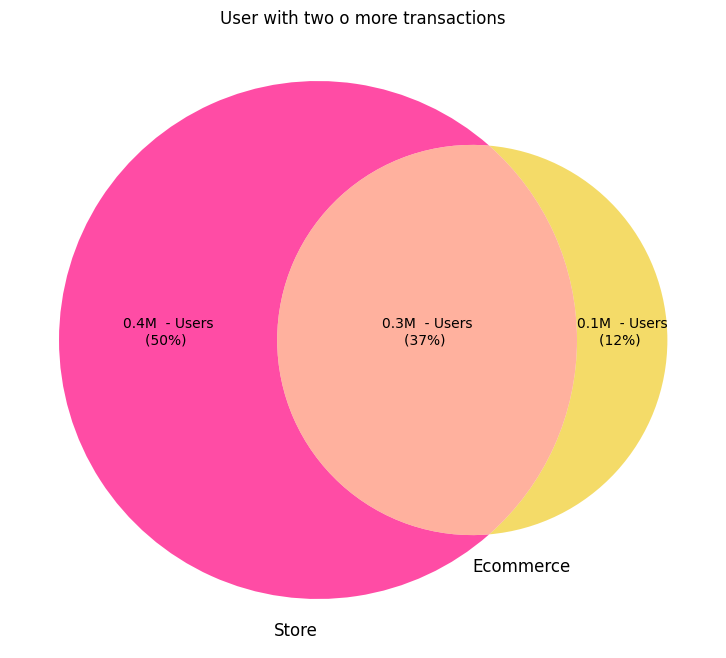

In [99]:
# Venn diagram - All users with 2 o more transactions

plt.style.use(['default'])

plt.figure(figsize=(10,8), edgecolor="white")

total = users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0]  + users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0] + users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]
total_transactions = users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_TRANSACTIONS"].values[0] + users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_TRANSACTIONS"].values[0] + users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_TRANSACTIONS"].values[0]


v = venn2((
    users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0], 
    users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0],
    users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]
    ),
    set_labels = ('Store', 'Ecommerce'), 
    set_colors=('#ff007f', '#f0cd28'),
    alpha = 0.7
    )

plt.title("User with two o more transactions", fontsize=12)

v.get_label_by_id('10').set_text(f"""
{np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0]/1e6,1)}M  - Users
({int(100 * np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0]/total,2))}%) 

""")
v.get_label_by_id('01').set_text(f"""
{np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0]/1e6,1)}M  - Users
({int(100 * np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0]/total,2))}%) 

""")
v.get_label_by_id('11').set_text(f"""
{np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]/1e6,1)}M  - Users
({int(100 * np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]/total,2))}%) 

""")
 


plt.show()

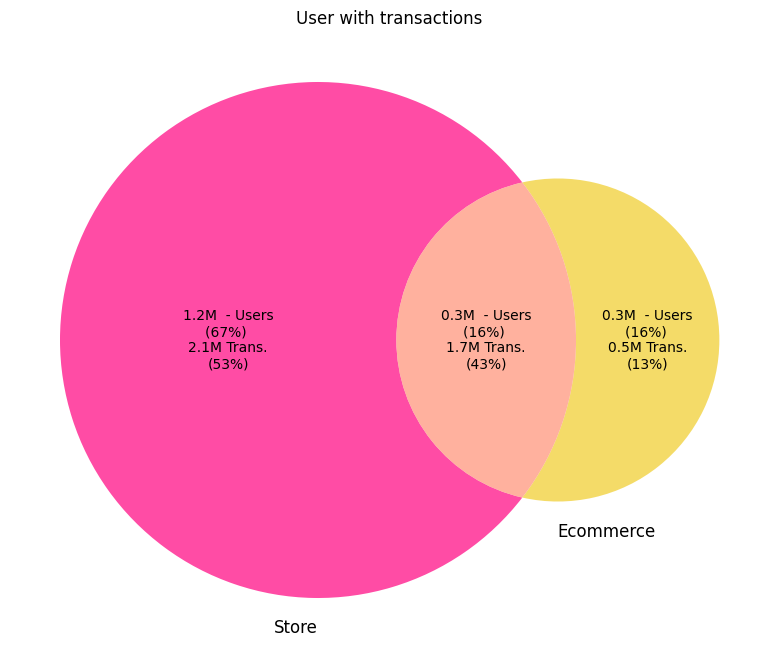

In [20]:
# Venn diagram - All users

plt.style.use(['default'])

plt.figure(figsize=(10,8), edgecolor="white")

total = users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0]  + users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0] + users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]
total_transactions = users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_TRANSACTIONS"].values[0] + users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_TRANSACTIONS"].values[0] + users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_TRANSACTIONS"].values[0]


v = venn2((
    users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0], 
    users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0],
    users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]
    ),
    set_labels = ('Store', 'Ecommerce'), 
    set_colors=('#ff007f', '#f0cd28'),
    alpha = 0.7
    )

plt.title("User with transactions", fontsize=12)

v.get_label_by_id('10').set_text(f"""
{np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0]/1e6,1)}M  - Users
({int(100 * np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0]/total,2))}%) 
{np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_TRANSACTIONS"].values[0]/1e6,1)}M Trans.
({int(100 * np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_TRANSACTIONS"].values[0]/total_transactions,2))}%)
""")
v.get_label_by_id('01').set_text(f"""
{np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0]/1e6,1)}M  - Users
({int(100 * np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0]/total,2))}%) 
{np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_TRANSACTIONS"].values[0]/1e6,1)}M Trans.
({int(100 * np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_TRANSACTIONS"].values[0]/total_transactions,2))}%)
""")
v.get_label_by_id('11').set_text(f"""
{np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]/1e6,1)}M  - Users
({int(100 * np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]/total,2))}%) 
{np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_TRANSACTIONS"].values[0]/1e6,1)}M Trans.
({int(100 * np.round(users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_TRANSACTIONS"].values[0]/total_transactions,2))}%)
""")
 


plt.show()

In [100]:
# Users with a valid gclid 
sql = f"""

WITH USERS_WITH_GCLID AS (
SELECT 
  CUSTOMER_KEY
FROM
  "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
WHERE 
  GCL_ID IS NOT NULL
)

SELECT
  SALES_CHANNEL,
  COUNT(DISTINCT CUSTOMER_KEY) as TOTAL_CUSTOMER_KEYS,
  SUM(N_TRANSACTIONS) as TOTAL_TRANSACTIONS
FROM "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
WHERE SALES_CHANNEL IS NOT NULL
AND CUSTOMER_KEY IN (SELECT * FROM USERS_WITH_GCLID)
AND CUSTOMER_KEY IN (
SELECT
  CUSTOMER_KEY
FROM 
  "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
GROUP BY 1
HAVING SUM(N_TRANSACTIONS) > 1
)
GROUP BY SALES_CHANNEL

UNION ALL

SELECT
  'STORE AND ECOMMERCE' AS SALES_CHANNEL,
  COUNT(DISTINCT CUSTOMER_KEY) as TOTAL_CUSTOMER_KEYS,
  SUM(N_TRANSACTIONS) as TOTAL_TRANSACTIONS
FROM "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
WHERE SALES_CHANNEL IS NOT NULL
AND CUSTOMER_KEY IN (SELECT * FROM USERS_WITH_GCLID)
AND CUSTOMER_KEY IN (
  SELECT
    CUSTOMER_KEY
  FROM 
    "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
  WHERE 
    SALES_CHANNEL IS NOT NULL
  GROUP BY CUSTOMER_KEY
  HAVING COUNT(DISTINCT SALES_CHANNEL) = 2
)
AND CUSTOMER_KEY IN (
SELECT
  CUSTOMER_KEY
FROM 
  "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
GROUP BY 1
HAVING SUM(N_TRANSACTIONS) > 1
)

UNION ALL

SELECT
  IFF(SALES_CHANNEL = 'ECOMMERCE', 'ECOMMERCE ONLY', 'STORE_ONLY') AS NEW_SALES_CHANNEL,
  COUNT(DISTINCT CUSTOMER_KEY) as TOTAL_CUSTOMER_KEYS,
  SUM(N_TRANSACTIONS) as TOTAL_TRANSACTIONS
FROM 
    "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
WHERE SALES_CHANNEL IS NOT NULL
AND CUSTOMER_KEY IN (SELECT * FROM USERS_WITH_GCLID)
AND CUSTOMER_KEY NOT IN (
  SELECT
      CUSTOMER_KEY
  FROM 
    "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
  WHERE 
    SALES_CHANNEL IS NOT NULL
  GROUP BY CUSTOMER_KEY
  HAVING COUNT(DISTINCT SALES_CHANNEL) = 2
)
AND CUSTOMER_KEY IN (
SELECT
  CUSTOMER_KEY
FROM 
  "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
GROUP BY 1
HAVING SUM(N_TRANSACTIONS) > 1
)
GROUP BY SALES_CHANNEL


UNION ALL

SELECT
  'TOTAL' as SALES_CHANNEL,
  COUNT(DISTINCT CUSTOMER_KEY) as TOTAL_CUSTOMER_KEYS,
  SUM(N_TRANSACTIONS) as TOTAL_TRANSACTIONS
FROM "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
WHERE SALES_CHANNEL IS NOT NULL
AND CUSTOMER_KEY IN (SELECT * FROM USERS_WITH_GCLID)
AND CUSTOMER_KEY IN (
SELECT
  CUSTOMER_KEY
FROM 
  "DATASET_ID"."LTV"."STG_GA_{banner}_TRANSACTED_CUSTOMER_KEY_GCLID_MAPPING_{last_run}"
GROUP BY 1
HAVING SUM(N_TRANSACTIONS) > 1
)

"""
users_gclid_transactions = session.sql(sql).to_pandas()
users_gclid_transactions.head()

,SALES_CHANNEL,TOTAL_CUSTOMER_KEYS,TOTAL_TRANSACTIONS
0,STORE AND ECOMMERCE,37586,343992
1,TOTAL,55899,428347
2,STORE,42809,180324
3,STORE_ONLY,5223,24568
4,ECOMMERCE,50676,248023


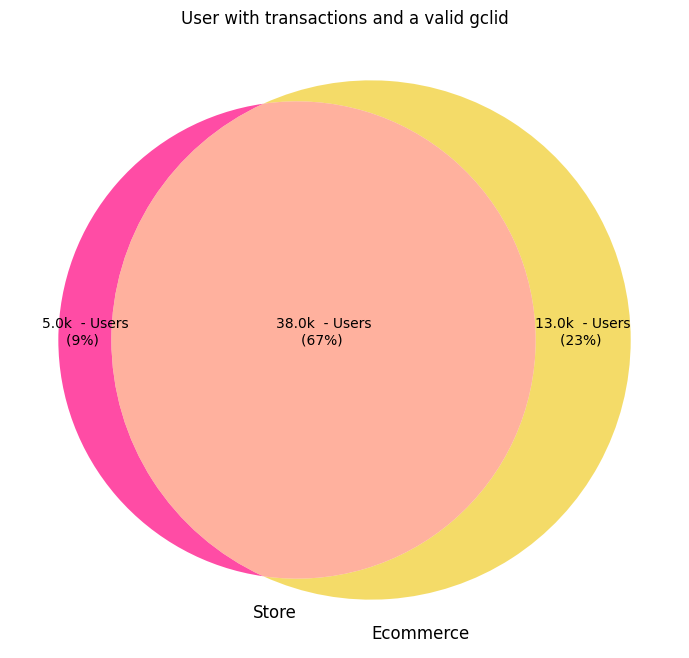

In [102]:
# Venn diagram

plt.style.use(['default'])

plt.figure(figsize=(10,8), edgecolor="white")

total = users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0]  + users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0] + users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]
total_transactions = users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_TRANSACTIONS"].values[0] + users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_TRANSACTIONS"].values[0] + users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_TRANSACTIONS"].values[0]


v = venn2((
    users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0], 
    users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0],
    users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]
    ),
    set_labels = ('Store', 'Ecommerce'), 
    set_colors=('#ff007f', '#f0cd28'),
    alpha = 0.7
    )

plt.title("User with two o more transactions and a valid gclid", fontsize=12)

v.get_label_by_id('10').set_text(f"""
{np.round(users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0]/1e3,0)}k  - Users
({int(100 * np.round(users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0]/total,2))}%) 

""")
v.get_label_by_id('01').set_text(f"""
{np.round(users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0]/1e3,0)}k  - Users
({int(100 * np.round(users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0]/total,2))}%) 

""")
v.get_label_by_id('11').set_text(f"""
{np.round(users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]/1e3,0)}k  - Users
({int(100 * np.round(users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]/total,2))}%) 

""")
 


plt.show()

### Funnel-like chart to show the distribution of users between the different type of transactions and if they have or not a valid gclid

In [105]:
import plotly.express as px
import pandas as pd
stages = ["Total users","Users with valid gclid"]

df_store = pd.DataFrame(dict(number=[
    users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0],
    users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0], 
    #users_gclid_90days_transactions.loc[users_gclid_90days_transactions.SALES_CHANNEL=="STORE_ONLY","TOTAL_CUSTOMER_KEYS"].values[0]
    
    
], stage=stages))
df_store['Type of Transaction'] = 'Store Only'

df_ecommerce = pd.DataFrame(dict(number=[
    users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0],
    users_transactions.loc[users_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0],
    #users_gclid_90days_transactions.loc[users_gclid_90days_transactions.SALES_CHANNEL=="ECOMMERCE ONLY","TOTAL_CUSTOMER_KEYS"].values[0]
    
    
], stage=stages))
df_ecommerce['Type of Transaction'] = 'Ecommerce Only'

df_both = pd.DataFrame(dict(number=[
    users_transactions.loc[users_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0],
    users_gclid_transactions.loc[users_gclid_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0],
   # users_gclid_90days_transactions.loc[users_gclid_90days_transactions.SALES_CHANNEL=="STORE AND ECOMMERCE","TOTAL_CUSTOMER_KEYS"].values[0]    
], stage=stages))
df_both['Type of Transaction'] = 'Both Store and Ecommerce'

df = pd.concat([df_store, df_ecommerce, df_both], axis=0)
fig = px.funnel(df, x='number', y='stage', color='Type of Transaction',width=1400, height=500)

fig.update_layout(legend=dict(
    yanchor="bottom",
    y=-0.3,
    xanchor="center",
    x=0.5
))

fig.show()

# Working with Lifetimes

For all models, the following nomenclature is used:

* _frequency_ represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
* _T_ represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
* _recency_ represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)
* _monetary_value_ represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

This four dimensions can be created using SQL or transactional data can be imported directly and Lifetimes can transform it to the needed shape

### Lifetimes : loading transactional data (All, STORE and ECOMMERCE and for all users)

In [24]:
sql = f"""
SELECT
    CUSTOMER_KEY,
    NEW_DATE as DEMAND_ORDER_DATE,
    AMOUNT_AFTER_DICOUNT as TOTAL_DEMAND_AMT
FROM
    "DATASET_ID"."LTV"."STG_CUSTOMER_TRANSACTIONS_{banner}"
"""
df_transactional= session.sql(sql).to_pandas()
# Saving as csv for future uses
df_transactional.to_csv('transactional_data.csv')

In [3]:
# Loading csv
df_transactional = pd.read_csv("transactional_data.csv", index_col=0)
df_transactional.head()

,CUSTOMER_KEY,DEMAND_ORDER_DATE,TOTAL_DEMAND_AMT
0,f8156eb450d73e29359b5deb4bbd29ef,2021-07-15,77.94
1,f8156eb450d73e29359b5deb4bbd29ef,2021-07-25,71.94
2,f8156eb450d73e29359b5deb4bbd29ef,2022-03-27,53.07
3,f81572eaf7cfb93c4d16f173f21fdf3b,2021-04-09,301.50
4,f81572eaf7cfb93c4d16f173f21fdf3b,2021-10-22,200.58


In [4]:
df_transactional.DEMAND_ORDER_DATE.max()

'2023-02-28'

### Exploratory Data Analysis

* Number of total users 
* Number of transactions (this is not the same that frequency)
* Number of transactions and avg monetary by month
* Montly repetition of users 
* Distribution of monetary
* Distribution of frequency
* Distribution of Age [T]
* Distribution of recency


In [5]:
# Number of users (different CUSTOMER_KEY)
df_transactional.CUSTOMER_KEY.nunique()

1728525

In [6]:
# Creating month columns
df_transactional["DEMAND_ORDER_DATE_format"]=pd.to_datetime(df_transactional["DEMAND_ORDER_DATE"])
df_transactional["DEMAND_ORDER_YEAR"] = df_transactional["DEMAND_ORDER_DATE_format"].dt.year
df_transactional["DEMAND_ORDER_MONTH"] = df_transactional["DEMAND_ORDER_DATE_format"].dt.month
df_transactional["DEMAND_ORDER_YEAR_MONTH"] = df_transactional["DEMAND_ORDER_YEAR"].apply(str) + '-' + df_transactional["DEMAND_ORDER_MONTH"].apply(str)
df_transactional.head()

,CUSTOMER_KEY,DEMAND_ORDER_DATE,TOTAL_DEMAND_AMT,DEMAND_ORDER_DATE_format,DEMAND_ORDER_YEAR,DEMAND_ORDER_MONTH,DEMAND_ORDER_YEAR_MONTH
0,f8156eb450d73e29359b5deb4bbd29ef,2021-07-15,77.94,2021-07-15,2021,7,2021-7
1,f8156eb450d73e29359b5deb4bbd29ef,2021-07-25,71.94,2021-07-25,2021,7,2021-7
2,f8156eb450d73e29359b5deb4bbd29ef,2022-03-27,53.07,2022-03-27,2022,3,2022-3
3,f81572eaf7cfb93c4d16f173f21fdf3b,2021-04-09,301.50,2021-04-09,2021,4,2021-4
4,f81572eaf7cfb93c4d16f173f21fdf3b,2021-10-22,200.58,2021-10-22,2021,10,2021-10


In [7]:
# Transactions by month
monthly_transaction_data = pd.DataFrame()
monthly_transaction_data["TRANSACTIONS"] = df_transactional.groupby(["DEMAND_ORDER_YEAR_MONTH"]).count()[["DEMAND_ORDER_DATE"]]
monthly_transaction_data.reset_index(inplace=True)
monthly_transaction_data["TOTAL_REVENUE"] = df_transactional.groupby(["DEMAND_ORDER_YEAR_MONTH"]).sum()[["TOTAL_DEMAND_AMT"]].reset_index()[["TOTAL_DEMAND_AMT"]]
monthly_transaction_data["AVERAGE_REVENUE"] = df_transactional.groupby(["DEMAND_ORDER_YEAR_MONTH"]).mean()[["TOTAL_DEMAND_AMT"]].reset_index()[["TOTAL_DEMAND_AMT"]]
monthly_transaction_data.head()

,DEMAND_ORDER_YEAR_MONTH,TRANSACTIONS,TOTAL_REVENUE,AVERAGE_REVENUE
0,2021-10,182803,21693638.11,118.672222
1,2021-11,265944,29410295.95,110.588304
2,2021-12,271389,23217495.53,85.550614
3,2021-3,122332,12499466.80,102.176592
4,2021-4,103341,11227641.07,108.646530


<AxesSubplot:title={'center':'Average Order value'}, xlabel='Month', ylabel='CAD$'>

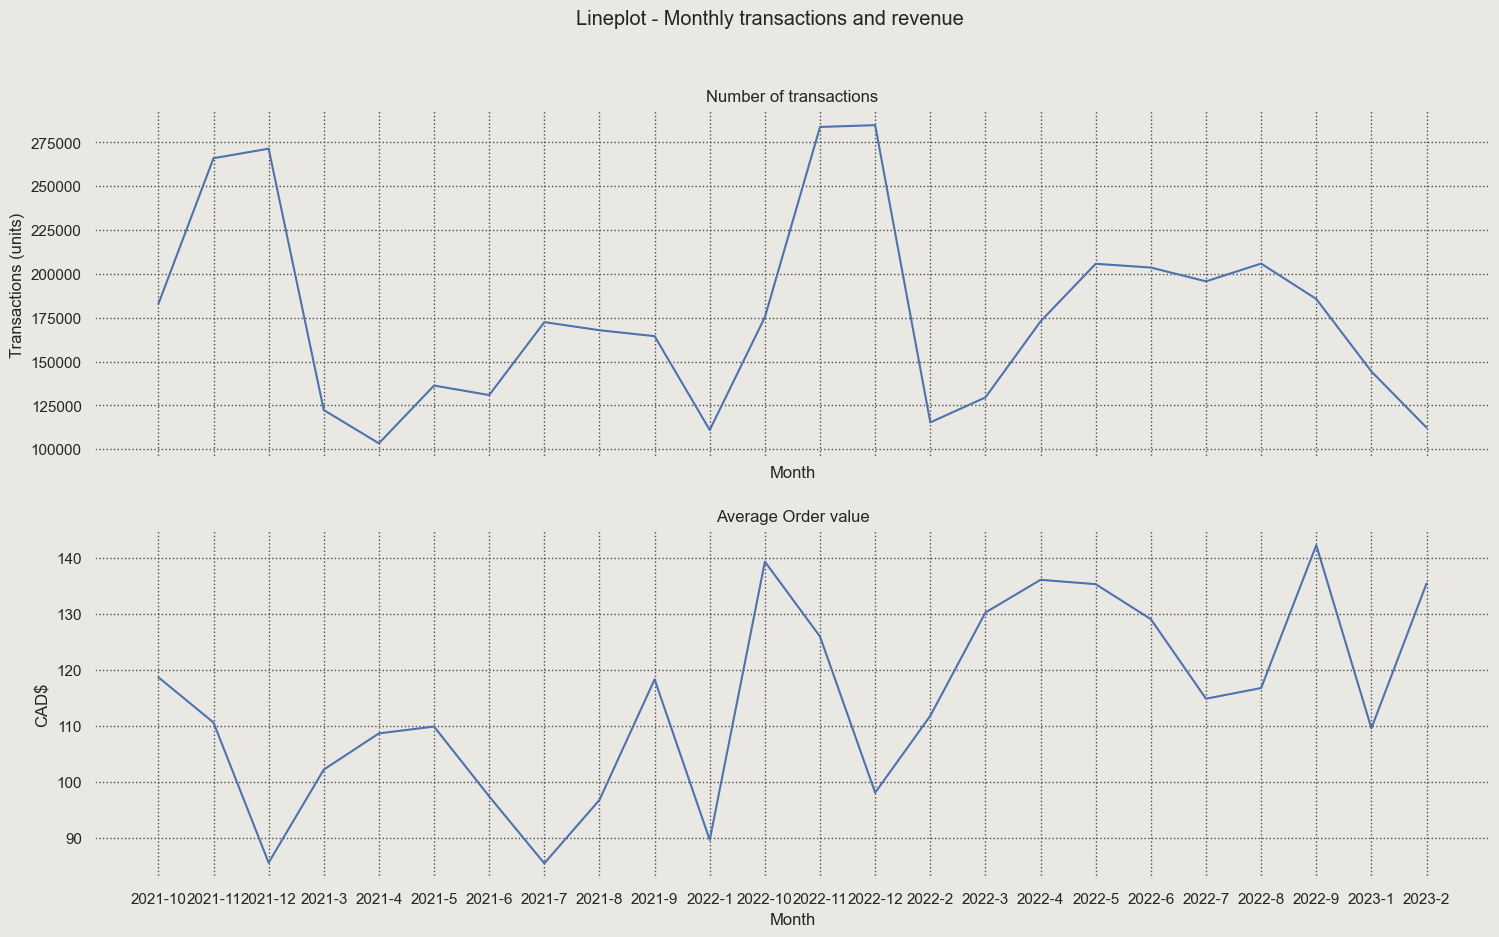

In [108]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18,10))

fig.suptitle('Lineplot - Monthly transactions and revenue')

axes[0].set_title('Number of transactions')
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Transactions (units)")

axes[1].set_title(f'Average Order value')
axes[1].set_xlabel("Month")
axes[1].set_ylabel("CAD$")



sns.lineplot(
    ax=axes[0],
    data=monthly_transaction_data.reset_index(), 
    x = "DEMAND_ORDER_YEAR_MONTH",
    y= "TRANSACTIONS"
)

sns.lineplot(
    ax=axes[1],
    data=monthly_transaction_data.reset_index(), 
    x = "DEMAND_ORDER_YEAR_MONTH",
    y= "AVERAGE_REVENUE"
)



In [109]:
# First we use a builtin function to transform transactional data into the F_R_M_T shape

from lifetimes.utils import summary_data_from_transaction_data

df_lifetimes = summary_data_from_transaction_data(
    df_transactional,
    customer_id_col="CUSTOMER_KEY",
    datetime_col= "DEMAND_ORDER_DATE",
    monetary_value_col="TOTAL_DEMAND_AMT",
    #observation_period_end = "2022-12-31",
    freq="W"
)

df_lifetimes.head()

,frequency,recency,T,monetary_value
CUSTOMER_KEY,,,,
0000116f2a952d53f78a257ba53f0663,7.000,61.000,90.000,72.969
000034c5f1916ca06181de607aab7756,0.000,0.000,80.000,0.000
00003abcf5590f9800daa86b8a25b842,0.000,0.000,66.000,0.000
00004372893b2a2de10eb674ddd83531,0.000,0.000,23.000,0.000
000044450b7ce666f3e960ddc1e0438b,0.000,0.000,14.000,0.000


In [110]:
# Lifetimes doesn't work with transaction, but it works with days. 
# We add the calculation of the number of transactions

transactions_by_user = df_transactional.groupby("CUSTOMER_KEY").count()[["DEMAND_ORDER_DATE"]]

transactions_by_user.rename(
    columns={"DEMAND_ORDER_DATE":"transactions"}, 
    inplace= True
)


In [116]:
# Comparison between transactions and frequency

transactions = pd.DataFrame(transactions_by_user.value_counts()).reset_index().rename(columns={0:"users"})
frequency_users = df_lifetimes.reset_index().groupby("frequency").count()[["CUSTOMER_KEY"]].reset_index()

data = {
    "One transaction in the full period" : transactions[transactions.transactions==1]["users"].values[0],
    "Two or more transactions in the full period" : transactions[transactions.transactions>1].sum()["users"],

    "Users with only one week with transactions in the full period" : frequency_users[frequency_users.frequency==0].sum()["CUSTOMER_KEY"],
    "User with transactions in two o more weeks": frequency_users[frequency_users.frequency>0].sum()["CUSTOMER_KEY"],
    
    "Total": frequency_users.CUSTOMER_KEY.sum()
}

resume_df = pd.DataFrame.from_dict(data=data, orient="index")
resume_df

,0
One transaction in the full period,"969,512.000"
Two or more transactions in the full period,"759,013.000"
Users with only one week with transactions in the full period,"1,025,761.000"
User with transactions in two o more weeks,"702,764.000"
Total,"1,728,525.000"


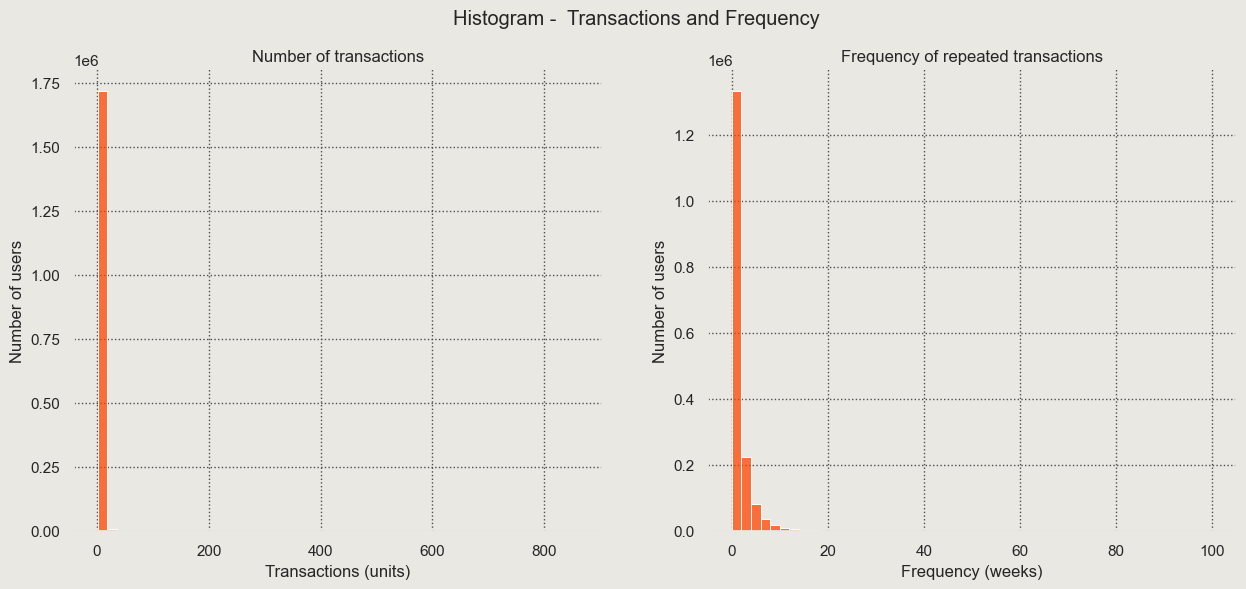

In [117]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,6))

fig.suptitle('Histogram -  Transactions and Frequency')

axes[0].set_title('Number of transactions')
axes[0].set_xlabel("Transactions (units)")
axes[0].set_ylabel("Number of users")

axes[1].set_title(f'Frequency of repeated transactions')
axes[1].set_xlabel("Frequency (weeks)")
axes[1].set_ylabel("Number of users")


hist1 = sns.histplot(
    ax = axes[0],
    data = transactions_by_user,
    x = "transactions",
    bins= 50,
    color="orangered"
)


hist2 = sns.histplot(
    ax = axes[1],
    data = df_lifetimes,
    x = "frequency",
    bins= 50,
    color="orangered"
)

(0.0, 40.0)

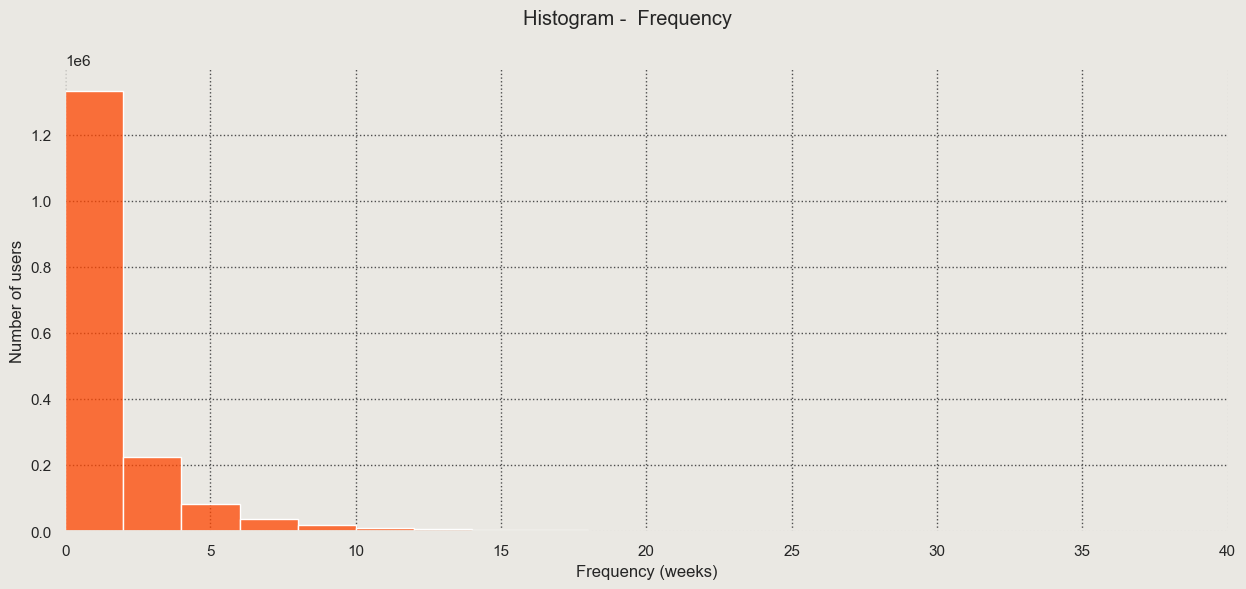

In [120]:
fig, axes = plt.subplots(1, 1, sharex=False, figsize=(15,6))

fig.suptitle('Histogram -  Frequency')

axes.set_xlabel("Frequency (weeks)")
axes.set_ylabel("Number of users")


hist2 = sns.histplot(
    ax = axes,
    data = df_lifetimes,
    x = "frequency",
    bins= 50,
    color="orangered"
)
axes.set_xlim([0,40])



Notes on chart above
* The distribution of number of transactions is extremelly right-skewed. About 50% of users have only one transaction and there are users with a very high number of purchases. When trying to plot an histogram, only the first bar is shown.
* The distribution of frequency is also right-skewed, but less than the transactions. Here we are plotting number of days. Frequency = 0 means you only bought once.

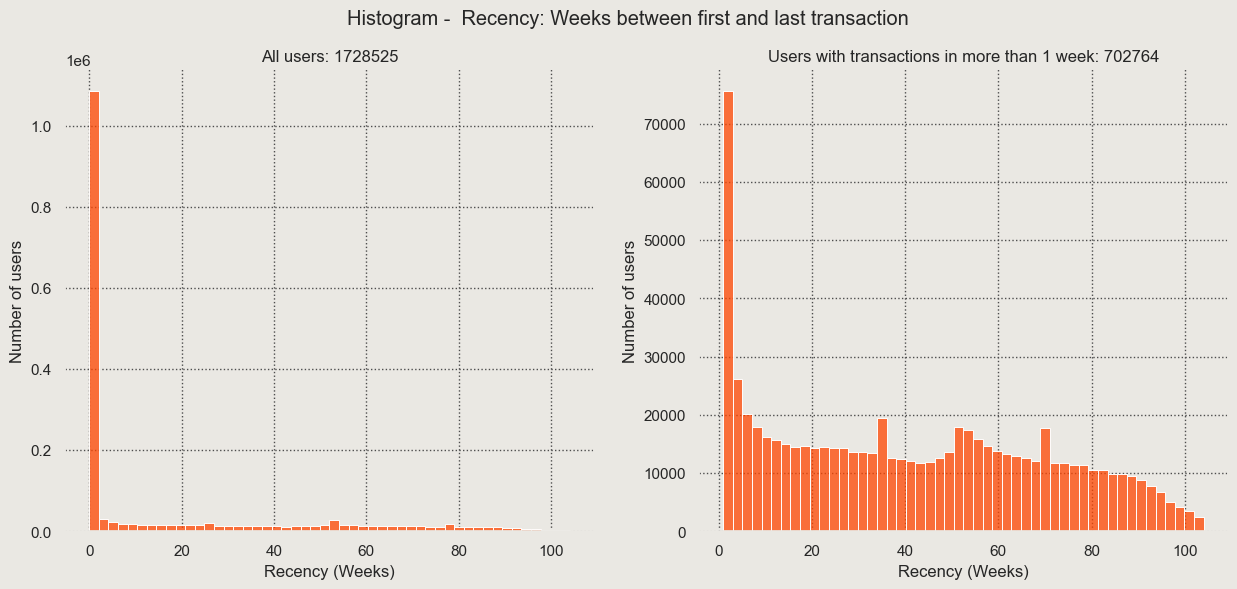

In [121]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,6))

fig.suptitle('Histogram -  Recency: Weeks between first and last transaction')

axes[0].set_title(f'All users: {df_transactional.CUSTOMER_KEY.nunique()}')
axes[0].set_xlabel("Recency (Weeks)")
axes[0].set_ylabel("Number of users")

axes[1].set_title(f'Users with transactions in more than 1 week: {df_lifetimes[df_lifetimes.recency>0].reset_index().CUSTOMER_KEY.nunique()}')
axes[1].set_xlabel("Recency (Weeks)")
axes[1].set_ylabel("Number of users")

hist1 = sns.histplot(
    ax= axes[0],
    data = df_lifetimes,
    x = "recency",
    bins= 50,
    color="orangered"
)

hist2 = sns.histplot(
    ax= axes[1],
    data = df_lifetimes[df_lifetimes.recency>0],
    x = "recency",
    bins= 50,
    color="orangered"
)


Notes about the cart above
* The pick in Recency 0 means that most of the users only have one transaction (LEFT)
* If we plot only the users with more than one transaction (RIGHT), the recency distribution is pretty uniform. There is a pick in recency = 1, but then all the recency have around 3000 users.

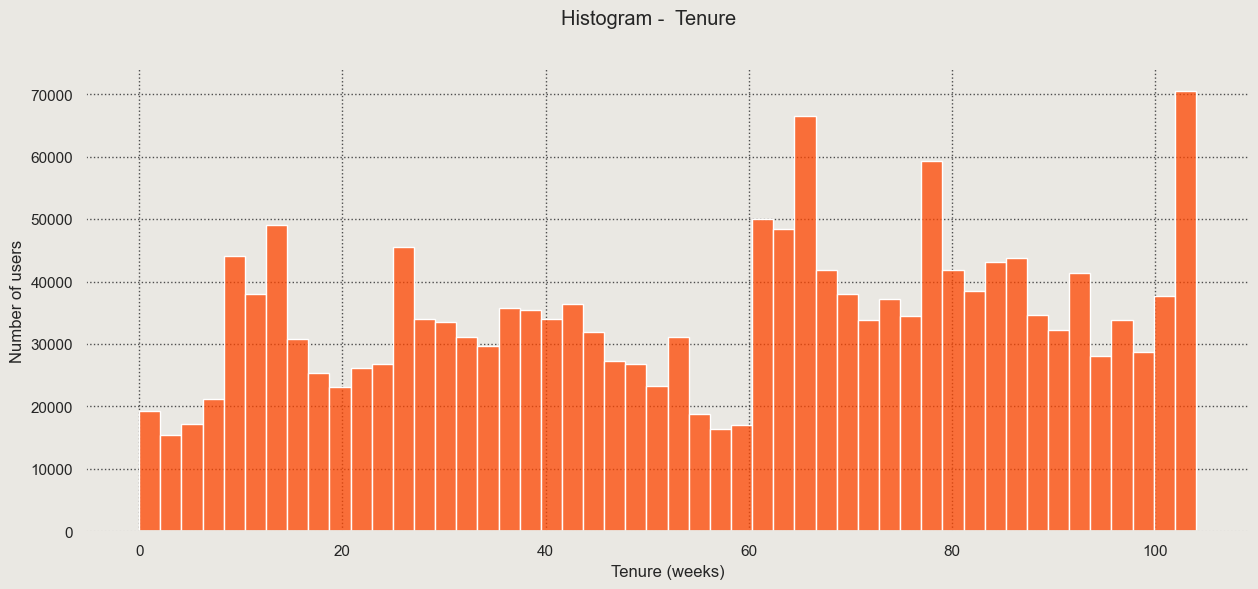

In [122]:
#Tenure 
fig, axes = plt.subplots(1, 1, sharex=False, figsize=(15,6))

fig.suptitle('Histogram -  Tenure')

axes.set_xlabel("Tenure (weeks)")
axes.set_ylabel("Number of users")


hist2 = sns.histplot(
    ax = axes,
    data = df_lifetimes,
    x = "T",
    bins= 50,
    color="orangered"
)

Monetary Value
* Lifetimes calculate the average monetary value by day SUM(monetary)/frequency
* When users have only one transaction, monetary value is zero because the frequency is zero and the division can't be calculated
* We also add the monetary value for users with only one transaction (just the value of the only transaction)

In [14]:
# Monetary value for users with only one transaction
monetary_amount = df_transactional[["CUSTOMER_KEY","DEMAND_ORDER_DATE","TOTAL_DEMAND_AMT"]].groupby("CUSTOMER_KEY").agg(('count', 'mean')).reset_index()
monetary_amount.columns = monetary_amount.columns.droplevel(0)
monetary_amount.columns = ["CUSTOMER_KEY", "COUNT", "TOTAL_DEMAND_AMT"]
monetary_amount.head()

,CUSTOMER_KEY,COUNT,TOTAL_DEMAND_AMT
0,0000116f2a952d53f78a257ba53f0663,9,61.466667
1,000034c5f1916ca06181de607aab7756,1,64.660000
2,00003abcf5590f9800daa86b8a25b842,1,71.880000
3,00004372893b2a2de10eb674ddd83531,1,33.680000
4,000044450b7ce666f3e960ddc1e0438b,1,48.550000


In [15]:
# Checking again users with only onw transaction
monetary_amount[monetary_amount["COUNT"]==1].CUSTOMER_KEY.nunique()

969512

In [16]:
# Checking users with calculated monetary value with lifetimes > 0
df_lifetimes[df_lifetimes.monetary_value>0].reset_index().CUSTOMER_KEY.nunique()

702724

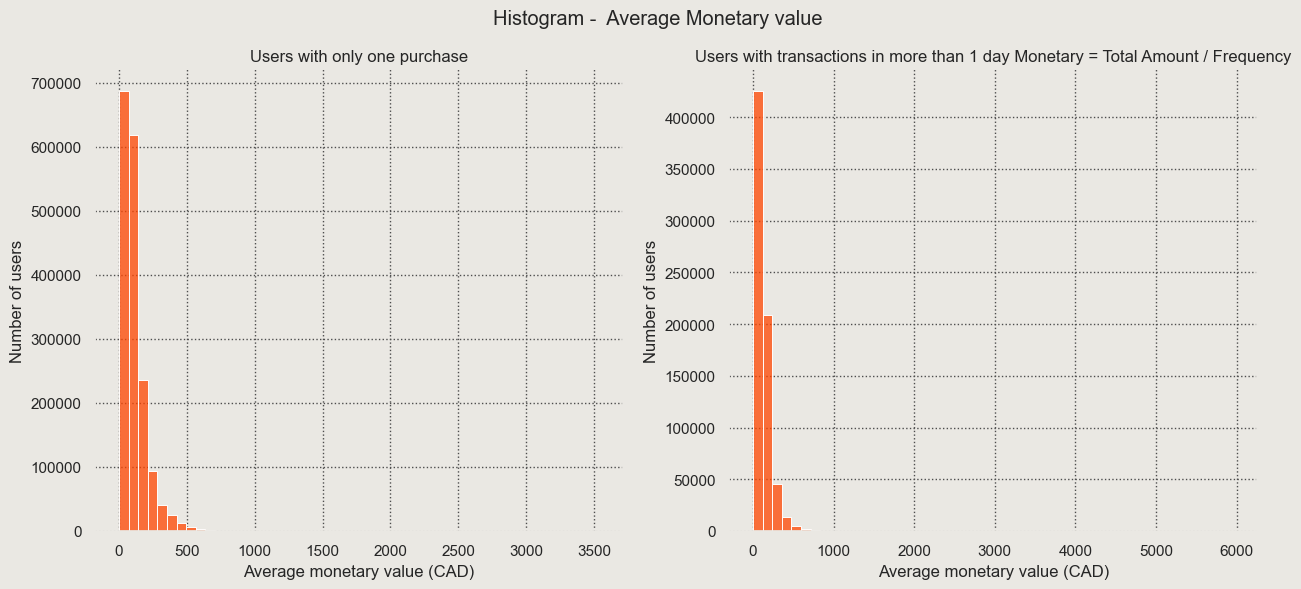

In [123]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,6))

fig.suptitle('Histogram -  Average Monetary value')

axes[0].set_title(f'Users with only one purchase')
axes[0].set_xlabel("Average monetary value (CAD)")
axes[0].set_ylabel("Number of users")

axes[1].set_title(f'Users with transactions in more than 1 day Monetary = Total Amount / Frequency')
axes[1].set_xlabel("Average monetary value (CAD)")
axes[1].set_ylabel("Number of users")

hist1 = sns.histplot(
    ax= axes[0],
    # There are some users with monetary == 0 (erros or promotions, there are only a few)
    data =  monetary_amount[monetary_amount.TOTAL_DEMAND_AMT>0],
    x = "TOTAL_DEMAND_AMT",
    bins= 50,
    #log_scale= True,
    color="orangered"
)

hist2 = sns.histplot(
    data = df_lifetimes[df_lifetimes.monetary_value>0],
    x = "monetary_value",
    bins= 50,
    #log_scale= True,
    color="orangered"
)

Notes about the cart above
* The distribution of monetary value is very similiar if we divide the users into two groups: users with only one transaction and users with frequency > 1. 
* In the first case, the value showed is the value of the transaction (the only transaction for each users)
* In the second case, the value showed is the total amount divided by the frequency.

### Split train y test (calibration y holdout)

In [19]:
outliers = list(df_lifetimes[df_lifetimes.frequency>105].reset_index()["CUSTOMER_KEY"].values)
df_transactional_filtered = df_transactional[df_transactional.CUSTOMER_KEY.apply(lambda x: x not in outliers )]

In [20]:
from lifetimes.utils import calibration_and_holdout_data

observation_period_end = "2023-02-28" # Last date in the dataset
calibration_period_end='2022-02-28' # Date to split between train and test

summary_cal_holdout = calibration_and_holdout_data(
    df_transactional, 
    customer_id_col="CUSTOMER_KEY",
    datetime_col= "DEMAND_ORDER_DATE",
    monetary_value_col="TOTAL_DEMAND_AMT",
    observation_period_end = observation_period_end,
    calibration_period_end = calibration_period_end,
    freq="W")

summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CUSTOMER_KEY,,,,,,,
0000116f2a952d53f78a257ba53f0663,4.0,25.0,38.0,85.405,3.0,42.29,52.0
000034c5f1916ca06181de607aab7756,0.0,0.0,28.0,0.000,0.0,0.00,52.0
00003abcf5590f9800daa86b8a25b842,0.0,0.0,14.0,0.000,0.0,0.00,52.0
000072f97c6f7e8f9c6041302422a456,1.0,12.0,52.0,284.700,3.0,123.90,52.0
00007371a03e6c24617b64becc85208b,0.0,0.0,10.0,0.000,0.0,0.00,52.0


In [21]:
# Train the model 
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases


bgf = BetaGeoFitter(penalizer_coef=0)

# We train it with the holdout dataset
bgf.fit(
    summary_cal_holdout['frequency_cal'], 
    summary_cal_holdout['recency_cal'], 
    summary_cal_holdout['T_cal'],
    verbose = True,   
    tol = 1e-06
    )


Optimization terminated successfully.
         Current function value: 0.204013
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34


<lifetimes.BetaGeoFitter: fitted with 958781 subjects, a: 0.41, alpha: 12.75, b: 1.96, r: 0.44>

Plots: model performance
1. Comparison between actual purchases in holdout period (second year) vs predicted purchases based on train data (from first year)
Only frequency up to 20 is shown. It corresponds with the 99.9% of the users (958033 users have 20 or less purchases, 748 users have more than 20 purchases)

In [22]:
print(f"""
Frequency in Calibration Period, percentile 0.999: {summary_cal_holdout.frequency_cal.quantile(q=0.999)}
Users with 20 or less purchases in calibration period: {summary_cal_holdout[summary_cal_holdout.frequency_cal<=20].count()['frequency_cal']}
Users with 20 or more purchases in calibration period:{summary_cal_holdout[summary_cal_holdout.frequency_cal>20].count()['frequency_cal']}
"""
)


Frequency in Calibration Period, percentile 0.999: 19.0
Users with 20 or less purchases in calibration period: 958033
Users with 20 or more purchases in calibration period:748



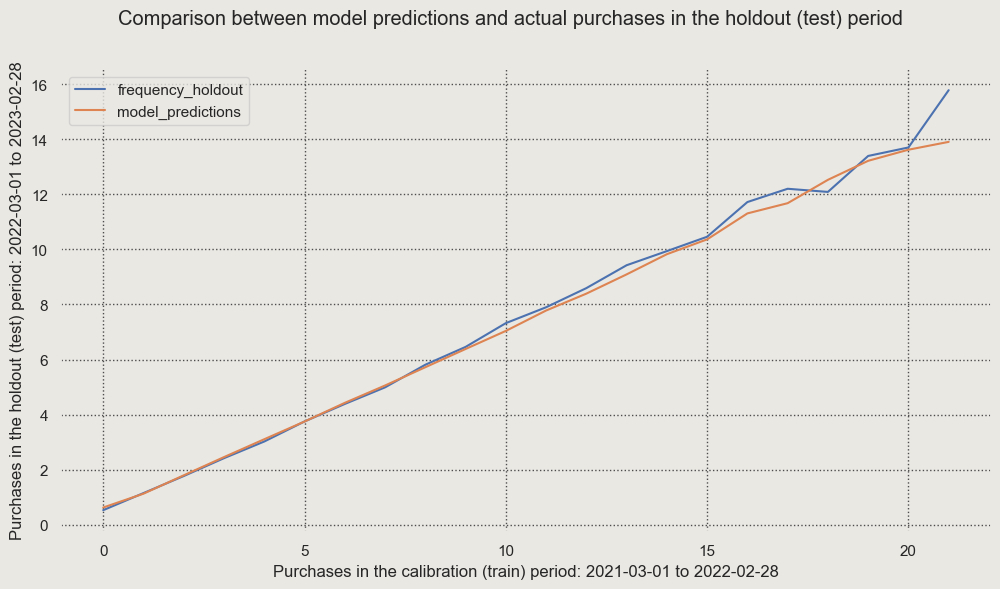

In [124]:
fig, axes = plt.subplots(1, 1, sharex=False, figsize=(12,6))

fig.suptitle('Comparison between model predictions and actual purchases in the holdout (test) period')

axes.set_title(f'All users: {df_transactional.CUSTOMER_KEY.nunique()}')
axes.set_xlabel("Ternure (weeks)")
axes.set_ylabel("Number of users")


hist1 = plot_calibration_purchases_vs_holdout_purchases(
    ax = axes,
    model=bgf, 
    calibration_holdout_matrix = summary_cal_holdout, 
    kind="frequency_cal", 
    n=22),
xlabel =(["1","2"])


axes.set_title('')

axes.set_xlabel("Purchases in the calibration (train) period: 2021-03-01 to 2022-02-28")
axes.set_ylabel("Purchases in the holdout (test) period: 2022-03-01 to 2023-02-28")

axes.legend()

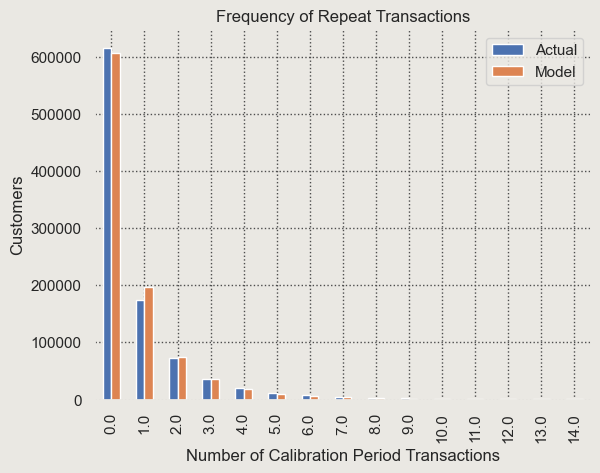

In [125]:
# This comparison only takes into account the period of calibration (train)
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(
    bgf,
    max_frequency=15);

### Run a new model training with all the dataset

In [33]:
df_transactional.head()

,CUSTOMER_KEY,DEMAND_ORDER_DATE,TOTAL_DEMAND_AMT,DEMAND_ORDER_DATE_format,DEMAND_ORDER_YEAR,DEMAND_ORDER_MONTH,DEMAND_ORDER_YEAR_MONTH
0,f8156eb450d73e29359b5deb4bbd29ef,2021-07-15,77.94,2021-07-15,2021,7,2021-7
1,f8156eb450d73e29359b5deb4bbd29ef,2021-07-25,71.94,2021-07-25,2021,7,2021-7
2,f8156eb450d73e29359b5deb4bbd29ef,2022-03-27,53.07,2022-03-27,2022,3,2022-3
3,f81572eaf7cfb93c4d16f173f21fdf3b,2021-04-09,301.50,2021-04-09,2021,4,2021-4
4,f81572eaf7cfb93c4d16f173f21fdf3b,2021-10-22,200.58,2021-10-22,2021,10,2021-10


In [34]:
# We use a builtin function to transform transactional data into the F_R_M_T shape
from lifetimes.utils import summary_data_from_transaction_data

df_lifetimes = summary_data_from_transaction_data(
    df_transactional,
    customer_id_col="CUSTOMER_KEY",
    datetime_col= "DEMAND_ORDER_DATE",
    monetary_value_col="TOTAL_DEMAND_AMT",
    observation_period_end = "2023-02-28",
    freq="W"
)

df_lifetimes.head()

,frequency,recency,T,monetary_value
CUSTOMER_KEY,,,,
0000116f2a952d53f78a257ba53f0663,7.0,61.0,90.0,72.968571
000034c5f1916ca06181de607aab7756,0.0,0.0,80.0,0.000000
00003abcf5590f9800daa86b8a25b842,0.0,0.0,66.0,0.000000
00004372893b2a2de10eb674ddd83531,0.0,0.0,23.0,0.000000
000044450b7ce666f3e960ddc1e0438b,0.0,0.0,14.0,0.000000


In [35]:
# Create other BetaGeoFitter object
bgf_full = BetaGeoFitter(penalizer_coef=0.05)

bgf_full.fit(
    df_lifetimes['frequency'], 
    df_lifetimes['recency'], 
    df_lifetimes['T'],    
    verbose = True,   
    tol = 1e-06
    )
bgf_full.summary

Optimization terminated successfully.
         Current function value: -0.260515
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.374414,0.000731,0.372980,0.375847
alpha,15.070790,0.043204,14.986111,15.155470
a,0.058570,0.000494,0.057603,0.059538
b,0.244522,0.001624,0.241340,0.247705


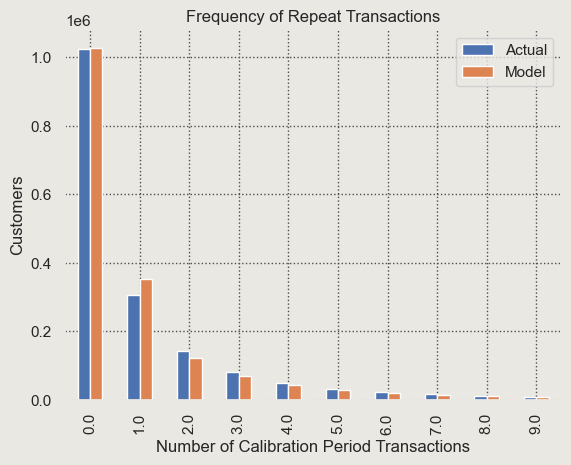

In [126]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(
    bgf_full,
    max_frequency=10);

In [ ]:
# Predictions
df_lifetimes['prediction_2_years'] = bgf_full.predict(
    104, 
    df_lifetimes['frequency'], 
    df_lifetimes['recency'], 
    df_lifetimes['T']  
    );

In [38]:
df_lifetimes.head()

,frequency,recency,T,monetary_value,prediction_2_years
CUSTOMER_KEY,,,,,
0000116f2a952d53f78a257ba53f0663,7.0,61.0,90.0,72.968571,6.463061
000034c5f1916ca06181de607aab7756,0.0,0.0,80.0,0.000000,0.373426
00003abcf5590f9800daa86b8a25b842,0.0,0.0,66.0,0.000000,0.433538
00004372893b2a2de10eb674ddd83531,0.0,0.0,23.0,0.000000,NaN
000044450b7ce666f3e960ddc1e0438b,0.0,0.0,14.0,0.000000,NaN


### Gamma-Gamma Model for Monetary value

This model only applies to users with more than 1 transactions (frequency > 1)

In [39]:
df_lifetimes[df_lifetimes.frequency == 0].count()

frequency             1025761
recency               1025761
T                     1025761
monetary_value        1025761
prediction_2_years     667415
dtype: int64

In [40]:
# Creating a copy only for users with more than one transaction
df_lifetimes_rep = df_lifetimes[df_lifetimes.monetary_value > 0]
df_lifetimes_rep.head()

,frequency,recency,T,monetary_value,prediction_2_years
CUSTOMER_KEY,,,,,
0000116f2a952d53f78a257ba53f0663,7.0,61.0,90.0,72.968571,6.463061
000072f97c6f7e8f9c6041302422a456,4.0,76.0,104.0,164.100000,3.523456
000087a2d80a36e04a5a367dc3a510c6,1.0,5.0,88.0,17.460000,0.408517
000097df5fe9e1c00bbc2eda07ba0f21,3.0,65.0,72.0,369.046667,3.771537
0000a210b631c31a59e43cc8d67ad566,1.0,13.0,58.0,67.420000,0.985708


In [41]:
# Check correlation between monetary and frequency - it should be low to use the model
df_lifetimes[["frequency","monetary_value"]].corr()

,frequency,monetary_value
frequency,1.000000,0.395328
monetary_value,0.395328,1.000000


In [42]:
df_lifetimes_rep[["frequency","monetary_value"]].corr()

,frequency,monetary_value
frequency,1.000000,0.053977
monetary_value,0.053977,1.000000


In [43]:
# Very low correlation, we can apply GammaGamma

In [44]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.05)
ggf.fit(df_lifetimes_rep['frequency'],
        df_lifetimes_rep['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 702724 subjects, p: 1.69, q: 0.28, v: 1.56>


In [45]:
# fitting the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef = 1e-06)
ggf.fit(
        frequency = df_lifetimes_rep["frequency"],
        monetary_value = df_lifetimes_rep["monetary_value"],  
        weights = None,   
        verbose = False,  
        tol = 1e-06,  
        q_constraint = True)
pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,2.839,0.007,2.824,2.853
q,3.540,0.008,3.524,3.557
v,116.486,0.492,115.523,117.450


In [46]:
# estimate the average transaction value of each customer, based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
        df_lifetimes_rep["frequency"],
        df_lifetimes_rep["monetary_value"])

df_lifetimes_rep["exp_avg_rev"] = exp_avg_rev
df_lifetimes_rep

,frequency,recency,T,monetary_value,prediction_2_years,exp_avg_rev
CUSTOMER_KEY,,,,,,
0000116f2a952d53f78a257ba53f0663,7.000,61.000,90.000,72.969,6.463,79.452
000072f97c6f7e8f9c6041302422a456,4.000,76.000,104.000,164.100,3.523,157.895
000087a2d80a36e04a5a367dc3a510c6,1.000,5.000,88.000,17.460,0.409,70.686
000097df5fe9e1c00bbc2eda07ba0f21,3.000,65.000,72.000,369.047,3.772,314.158
0000a210b631c31a59e43cc8d67ad566,1.000,13.000,58.000,67.420,0.986,97.051
...,...,...,...,...,...,...
fffeb5279d369c7e40e07f8ff4d48e56,38.000,101.000,103.000,64.768,33.004,66.273
ffff0e224ad0792582893670bd417def,1.000,17.000,20.000,69.900,2.976,98.360
ffffa3384b7e363c1a939a29d2ba1799,1.000,1.000,67.000,70.060,0.512,98.445


### Expected purchases + expected monetary to get LTV

In [47]:
# compute customer lifetime value
DISCOUNT_a = 0# 0.06                # annual discount rate
LIFE = 24                        # lifetime expected for the customers in months

discount_m = (1 + DISCOUNT_a)**(1/12) - 1     # monthly discount rate

clv = ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,  
        frequency = df_lifetimes_rep["frequency"],  
        recency = df_lifetimes_rep["recency"],  
        T = df_lifetimes_rep["T"],  
        monetary_value = df_lifetimes_rep["monetary_value"],  
        time = LIFE,    
        freq = "W",                          
        discount_rate = discount_m)

df_lifetimes_rep.insert(0, "CLV", clv)             # expected customer lifetime values
df_lifetimes_rep.head()

,CLV,frequency,recency,T,monetary_value,prediction_2_years,exp_avg_rev
CUSTOMER_KEY,,,,,,,
0000116f2a952d53f78a257ba53f0663,323.726,7.000,61.000,90.000,72.969,6.463,79.452
000072f97c6f7e8f9c6041302422a456,432.666,4.000,76.000,104.000,164.100,3.523,157.895
000087a2d80a36e04a5a367dc3a510c6,26.413,1.000,5.000,88.000,17.460,0.409,70.686
000097df5fe9e1c00bbc2eda07ba0f21,999.171,3.000,65.000,72.000,369.047,3.772,314.158
0000a210b631c31a59e43cc8d67ad566,92.769,1.000,13.000,58.000,67.420,0.986,97.051


Plots:
* Histogram of predicted CLV for users with more than 2 transactions in the full period. (Scale in X axis is not lineal)
  * 35000 users have a CLV of $250
  * 10000 users have a CLV of $1000 (high value)
  * 10000 users have a CLV of $50 (low value)
* Correlation plot between total monetary value in the two years period (sum of all the revenue) and the CLV. 
  * Both variables are divided in 10 percentiles

(10.0, 5000.0)

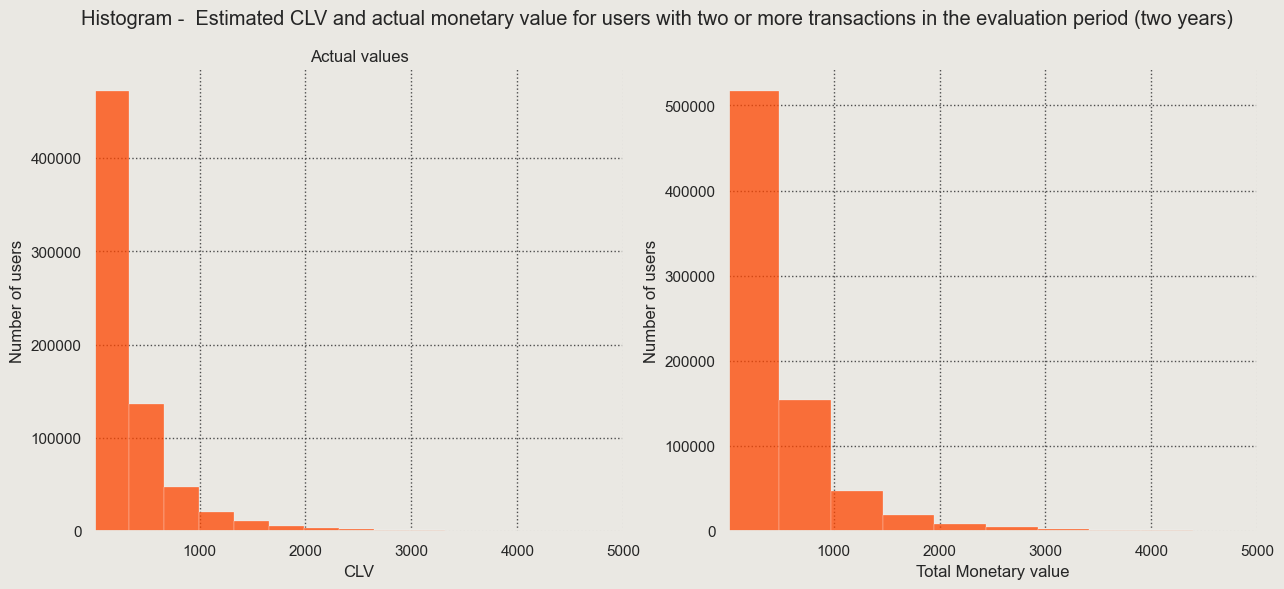

In [127]:
import matplotlib
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,6))

fig.suptitle('Histogram -  Estimated CLV and actual monetary value for users with two or more transactions in the evaluation period (two years)')

axes[0].set_title('Model Predictions')
axes[0].set_xlabel("CLV")
axes[0].set_ylabel("Number of users")
axes[0].set_title('Actual values')
axes[1].set_xlabel("Total Monetary value")
axes[1].set_ylabel("Number of users")

hist1 = sns.histplot(
    ax=axes[0],
    data = df_lifetimes_rep,
    x = "CLV",
    bins= 200, 
    color="orangered"
)

hist2 = sns.histplot(
    ax=axes[1],
    data = monetary_amount[monetary_amount["COUNT"]>1],
    x = "total",
    bins= 200, 
    color="orangered"
)


axes[0].set_xlim([10,5000])
axes[1].set_xlim([10,5000])

#axes.set_xticks([100,200,300,400])
#axes.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


In [137]:
# Adapting format for CLV
df_clv_plot = df_lifetimes_rep.reset_index()[['CUSTOMER_KEY', 'CLV']]
df_clv_plot['Variable'] = 'CLV'
# Adapting format for total monetary value
monetary_amount["total"] = monetary_amount["COUNT"]*monetary_amount["TOTAL_DEMAND_AMT"]
df_monetary_plot = monetary_amount[monetary_amount["COUNT"]>1][['CUSTOMER_KEY', 'TOTAL_DEMAND_AMT']]
df_monetary_plot.columns = ['CUSTOMER_KEY','CLV']
df_monetary_plot['Variable'] = 'Total Monetary Value'

# JOining both
df_clv_plot['Variable'] = 'CLV'
df_plot = pd.concat([df_clv_plot,df_monetary_plot], axis= 0)
df_plot.head()

,CUSTOMER_KEY,CLV,Variable
0,0000116f2a952d53f78a257ba53f0663,323.726,CLV
1,000072f97c6f7e8f9c6041302422a456,432.666,CLV
2,000087a2d80a36e04a5a367dc3a510c6,26.413,CLV
3,000097df5fe9e1c00bbc2eda07ba0f21,999.171,CLV
4,0000a210b631c31a59e43cc8d67ad566,92.769,CLV


(10.0, 3000.0)

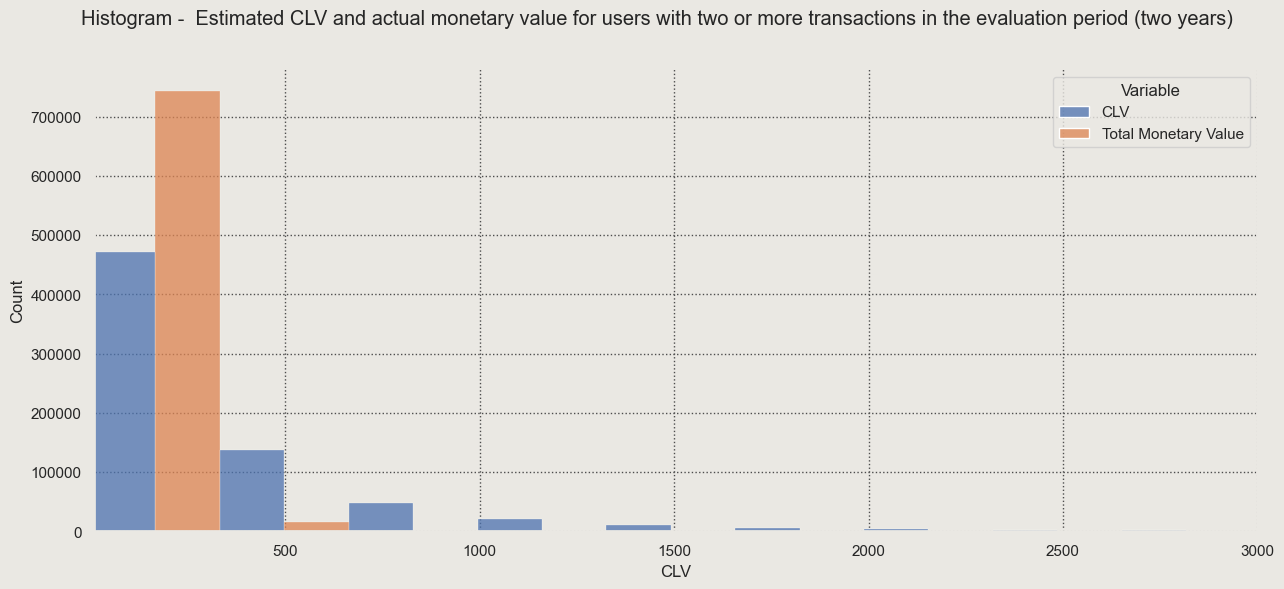

In [160]:
import matplotlib
fig, axes = plt.subplots(1, 1, sharex=False, figsize=(15,6))

fig.suptitle('Histogram -  Estimated CLV and actual monetary value for users with two or more transactions in the evaluation period (two years)')


hist1 = sns.histplot(
    ax=axes,
    data = df_plot.reset_index(),
    x = "CLV",
    hue="Variable",
    bins= 200, 
    multiple='dodge',
    
)

axes.set_xlim([10,3000])



In [58]:
monetary_amount["total"] = monetary_amount["COUNT"]*monetary_amount["TOTAL_DEMAND_AMT"]
monetary_amount.head()

,CUSTOMER_KEY,COUNT,TOTAL_DEMAND_AMT,total
0,0000116f2a952d53f78a257ba53f0663,9,61.467,553.200
1,000034c5f1916ca06181de607aab7756,1,64.660,64.660
2,00003abcf5590f9800daa86b8a25b842,1,71.880,71.880
3,00004372893b2a2de10eb674ddd83531,1,33.680,33.680
4,000044450b7ce666f3e960ddc1e0438b,1,48.550,48.550


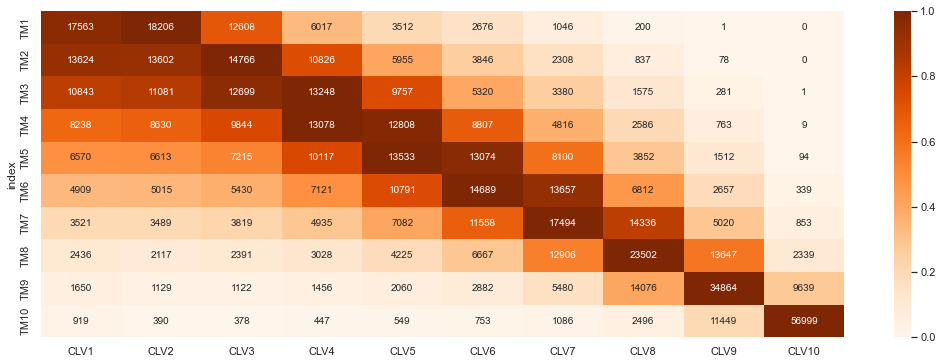

In [53]:
df_CLV = df_lifetimes_rep["CLV"]
df_CLV_q10 = pd.qcut(
    x=df_CLV,
    q=10,
    labels=["CLV1","CLV2","CLV3","CLV4","CLV5","CLV6","CLV7","CLV8","CLV9","CLV10"])

monetary_amount["total"] = monetary_amount["COUNT"]*monetary_amount["TOTAL_DEMAND_AMT"]

df_monetary = monetary_amount[monetary_amount.COUNT>1].set_index("CUSTOMER_KEY")['total']
df_monetary_q10 = pd.qcut(
    x=df_monetary,
    q=10,
    labels=["TM1","TM2","TM3","TM4","TM5","TM6","TM7","TM8","TM9","TM10"])

comparison = pd.DataFrame(df_CLV_q10).reset_index().merge(
    pd.DataFrame(df_monetary_q10).reset_index(),
    on = "CUSTOMER_KEY",
    how = "inner"
)

test = comparison.pivot_table(
    index= "total",
    columns= "CLV",
    aggfunc = "count"
)

test.reset_index(inplace=True)
test.columns =  ["index","CLV1","CLV2","CLV3","CLV4","CLV5","CLV6","CLV7","CLV8","CLV9","CLV10"]
test.set_index("index", inplace=True)

fig, axes = plt.subplots(1, 1, sharex=False, figsize=(18,6))


axes.set_xlabel("Clients Ternure (week)")
axes.set_ylabel("Number of users")

"""
g = sns.heatmap(
    ax=axes,
    data=test,
    cmap=sns.cubehelix_palette(as_cmap=True),
    annot=True,
    fmt='g',
    )
"""

g = sns.heatmap(
    ax=axes,
    data=test.div(test.max(axis=1), axis=0),
    cmap=sns.color_palette("Oranges", as_cmap=True),
    annot=test,
    fmt='g',
    )

### Output dataset at CUSTOMER KEY level

In [161]:
output_dataset = df_lifetimes_rep.reset_index()[["CUSTOMER_KEY","CLV"]]
output_dataset.head()

,CUSTOMER_KEY,CLV
0,0000116f2a952d53f78a257ba53f0663,323.726
1,000072f97c6f7e8f9c6041302422a456,432.666
2,000087a2d80a36e04a5a367dc3a510c6,26.413
3,000097df5fe9e1c00bbc2eda07ba0f21,999.171
4,0000a210b631c31a59e43cc8d67ad566,92.769


### Map final CLV table to the most recent GCLID for each user

In [171]:
# GET LAST GCLID for each CUSTOMER_KEY
sql = f"""

WITH customer_sessions AS (
SELECT
    CUSTOMER_KEY,
    SESSION_KEY
FROM
    DATASET_ID.INTERMEDIATE.INT_GA_CUSTOM_CUSTOMER_KEY
WHERE 
    BANNER = '{banner}'    
 
)

SELECT DISTINCT

    b.CUSTOMER_KEY,
    a.GCL_ID
    
FROM
    DATASET_ID.STAGING.STG_GA__SESSIONS_DAILY__TRAFFIC_SOURCE a 
LEFT JOIN customer_sessions b
ON(a.SESSION_KEY = b.SESSION_KEY)
WHERE 
    a.SESSION_DATE BETWEEN DATEADD(DAY,-90,CURRENT_DATE()) and CURRENT_DATE()
    AND a.GCL_ID is not NULL


"""
gclid = session.sql(sql).to_pandas()

In [172]:
gclid.head()

,CUSTOMER_KEY,GCL_ID
0,b8e51cb9ba1853086730c214668cc7c3,CjwKCAiAqt-dBhBcEiwATw-ggBbTissEnkp3VoGN4P1l_d...
1,336d5ebc5436534e61d16e63ddfca327,EAIaIQobChMIhLuFwOCX_QIVDubICh3LewyKEAAYASAAEg...
2,336d5ebc5436534e61d16e63ddfca327,EAIaIQobChMI09bbnfah_AIVia7ICh128QMgEAAYASAAEg...
3,336d5ebc5436534e61d16e63ddfca327,Cj0KCQiApKagBhC1ARIsAFc7Mc7UqUjRrhaSU89HQtAAG-...
4,3fb49795d8c7d067ad87fe4286a41a06,CjwKCAiA3pugBhAwEiwAWFzwdW2S0CewzvHjdkn_gTezST...


In [173]:
#Joining both using CUSTOMER_KEY
output_dataset = output_dataset.merge(
    gclid,
    on = "CUSTOMER_KEY",
    how = "inner"
)
output_dataset.head()

,CUSTOMER_KEY,CLV,GCL_ID
0,00026e2d37a009de1765d77842c788ee,"1,209.761",Cj0KCQiAic6eBhCoARIsANlox859Yq1ssUmCHfhfJflAZc...
1,00050c30c35e41ccd9cddabc497b6d36,519.718,CjwKCAiAzp6eBhByEiwA_gGq5Fd2EbTsieLIbP_R-drGdl...
2,00050c30c35e41ccd9cddabc497b6d36,519.718,CjwKCAiA2L-dBhACEiwAu8Q9YEacc8NEo9h53UEDRBcGyk...
3,0008f705c04c07fdcad2a746b2b4432c,523.482,Cj0KCQiAjbagBhD3ARIsANRrqEsm6DSqyYYzaTxLPZzTyR...
4,0009a442ae9c85ee592e0d1ae854fdd1,436.276,Cj0KCQiA6rCgBhDVARIsAK1kGPLc1tvDi7rbK1YsZapLUV...


In [174]:
output_dataset.shape

(127635, 3)

In [ ]:
# I need to modify the date format (there should be a better way to do this -_- )
import datetime
import pytz

# Create a csv to upload to google ads:
# Audience 1: users with a valid gclid in the last 90 days. 
data_to_gads = pd.DataFrame(columns=[
    "Google Click ID",
    "Conversion Name",
    "Conversion Time",
    "Conversion Value",
    "Conversion Currency"
])
data_to_gads["Google Click ID"] = output_dataset["GCL_ID"]
data_to_gads["Conversion Name"] = "conversion_test"
data_to_gads["Conversion Time"] = datetime.datetime(2023,3,20,10,0,0).strftime("%Y-%m-%d %H:%M:%S") + "-0500"
data_to_gads["Conversion Value"] = output_dataset["CLV"]
data_to_gads["Conversion Currency"] = "CAD"
# Save csv
data_to_gads.to_csv('output_2_upload_2_google_ads.csv')